In [1]:
# general libraries
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt


### Data Prep

In [29]:
cc_fraud = pd.read_csv('../data/full_fraud_dataset.csv',nrows=100000)
cc_fraud['full_name'] = cc_fraud['first'] + ' ' + cc_fraud['last']
print(cc_fraud.shape)

(100000, 26)


In [66]:
cc_fraud.columns

Index(['ssn', 'cc_num', 'first', 'last', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'acct_num', 'trans_num',
       'trans_date', 'trans_time', 'unix_time', 'category', 'amt', 'is_fraud',
       'merchant', 'merch_lat', 'merch_long', 'full_name'],
      dtype='object')

In [30]:
to_drop = ['ssn', 'cc_num', 'first', 'last', 'street', 'state', 'zip', 'acct_num', 'trans_num', 'unix_time']
cc_clean = cc_fraud.drop(to_drop, axis=1)

In [31]:
# pre-processing time
# transaction date
cc_clean['trans_datetime'] = pd.to_datetime(cc_clean['trans_date'])
cc_clean['trans_date'] = cc_clean['trans_datetime'].dt.date
cc_clean['trans_year'] = cc_clean['trans_datetime'].dt.year.astype(str)
cc_clean['trans_month'] = cc_clean['trans_datetime'].dt.month
cc_clean['trans_day'] = cc_clean['trans_datetime'].dt.day

# transaction time
cc_clean['trans_hour'] = cc_clean['trans_time'].str[:2].astype(int)

# convert month to string
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
cc_clean['trans_month_'] = cc_clean['trans_month'].map(month_map)

# convert time to part of day
def get_part_of_day(hour):
    """Return the part of day given the hour of day"""
    if (hour > 22) or (hour <= 6):
        return 'early morning'
    elif hour <= 11:
        return 'breakfast'
    elif hour <= 14:
        return 'lunch'
    elif hour <= 17:
        return 'afternoon'
    else:
        return 'dinner'
cc_clean.loc[:, 'part_of_day'] = cc_clean['trans_hour'].apply(get_part_of_day)

In [32]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [33]:
cc_clean['dob_datetime'] = pd.to_datetime(cc_clean['dob'])
cc_clean['dob'] = cc_clean['dob_datetime'].dt.date
cc_clean['age'] = (cc_clean['trans_date'] - cc_clean['dob'])/365
cc_clean['age'] = cc_clean['age'].apply(lambda x: x.days)

In [34]:
cc_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   gender          100000 non-null  object        
 1   city            100000 non-null  object        
 2   lat             100000 non-null  float64       
 3   long            100000 non-null  float64       
 4   city_pop        100000 non-null  int64         
 5   job             100000 non-null  object        
 6   dob             100000 non-null  object        
 7   trans_date      100000 non-null  object        
 8   trans_time      100000 non-null  object        
 9   category        100000 non-null  object        
 10  amt             100000 non-null  float64       
 11  is_fraud        100000 non-null  int64         
 12  merchant        100000 non-null  object        
 13  merch_lat       100000 non-null  float64       
 14  merch_long      100000 non-null  floa

In [20]:
cc_clean['merchant']

0                      MedStoreRx
1                Ever Supermarket
2          Nine Media Corporation
3                          Zalora
4                        Ubuy Co.
                   ...           
499995              Carlo Pacific
499996    Sawasdee Marketing Corp
499997            KCC Supermarket
499998      Mars Philippines Inc.
499999                       Ikea
Name: merchant, Length: 500000, dtype: object

## Exploratory Data Analysis

Number of transactions:


0    99076
1      924
Name: is_fraud, dtype: int64

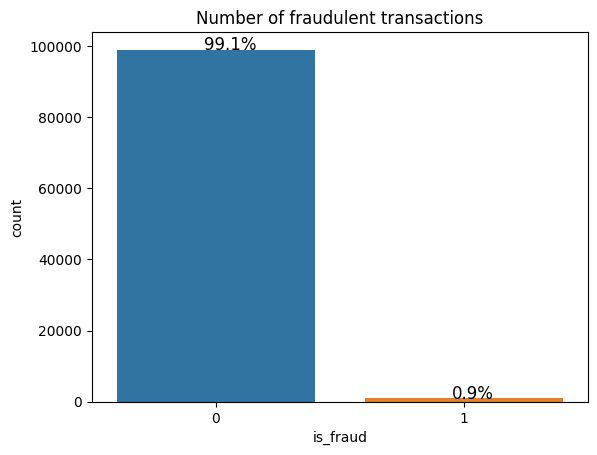

In [35]:
ax = sns.countplot(x='is_fraud',data=cc_clean)
plt.title("Number of fraudulent transactions")

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
        
without_hue(ax, cc_clean['is_fraud'])

print('Number of transactions:')
cc_clean['is_fraud'].value_counts()

Text(0.5, 1.0, 'Transactions by category')

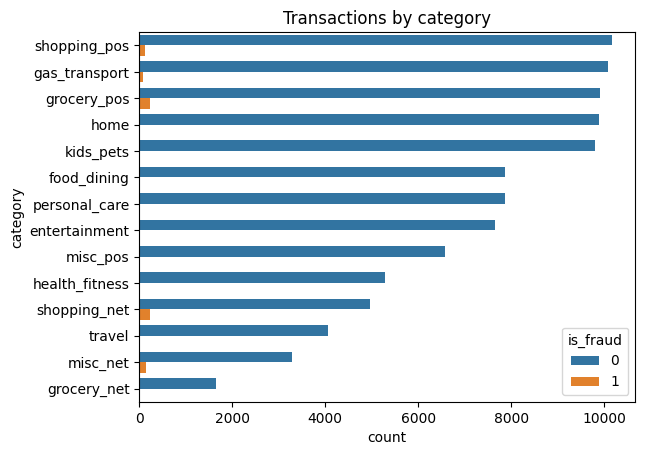

In [36]:
sns.countplot(y='category',hue= 'is_fraud',data=cc_clean, order = cc_clean['category'].value_counts().index)
plt.title('Transactions by category')

[Text(0.5, 1.0, 'Fraudulent transactions by category')]

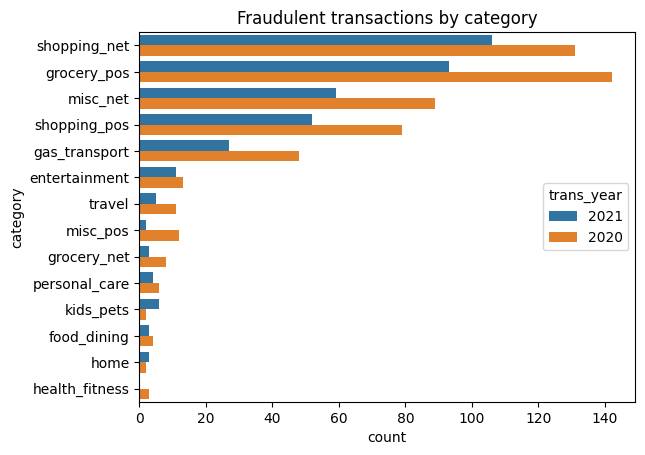

In [63]:
sns.countplot(y='category',hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1],
             order = cc_clean[cc_clean['is_fraud'] == 1]['category'].value_counts().index).set(
    title = 'Fraudulent transactions by category')



[Text(0.5, 1.0, 'Fraudulent transactions by Job')]

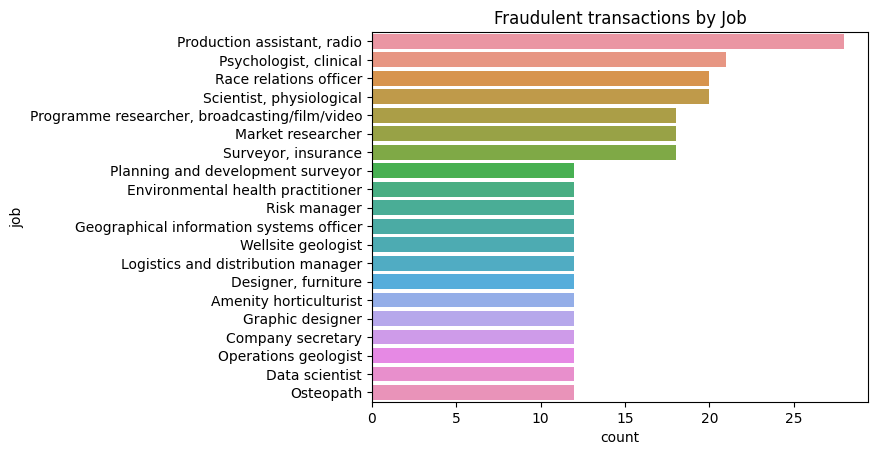

In [67]:
sns.countplot(y='job', data=cc_clean[cc_clean['is_fraud'] == 1],
            order = cc_clean[cc_clean['is_fraud'] == 1]['job'].value_counts().iloc[:20].index).set(
    title = 'Fraudulent transactions by Job'
)           

[Text(0.5, 1.0, 'Fraudulent transactions by merchant')]

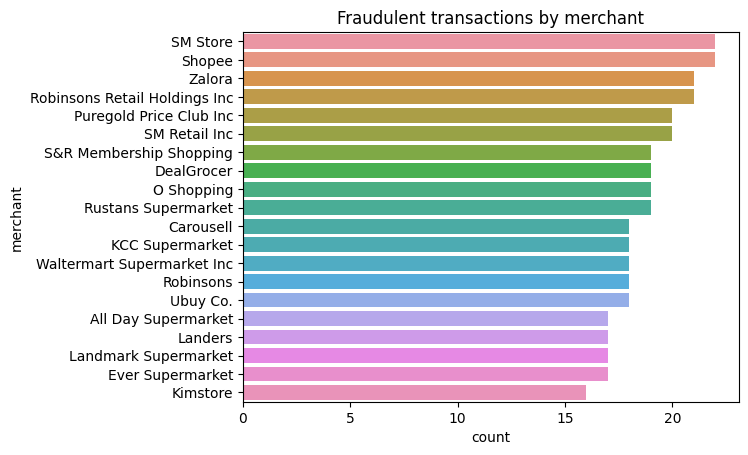

In [52]:
sns.countplot(y='merchant', data=cc_clean[cc_clean['is_fraud'] == 1],
            order = cc_clean[cc_clean['is_fraud'] == 1]['merchant'].value_counts().iloc[:20].index).set(
    title = 'Fraudulent transactions by merchant'
)            

[Text(0.5, 1.0, 'Amount of fraudulent transactions by merchant')]

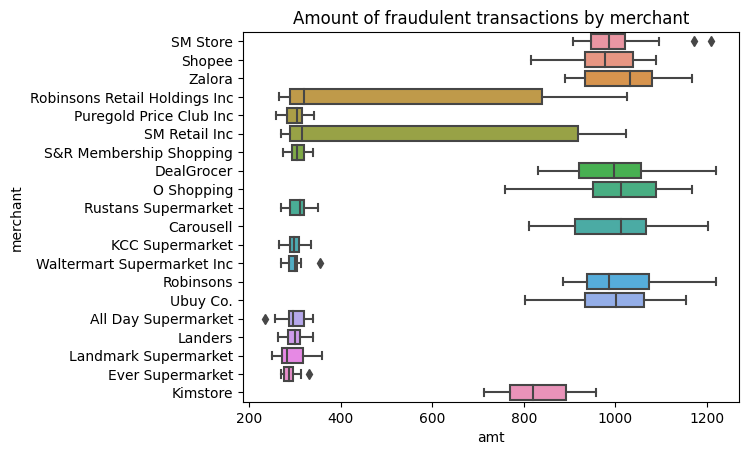

In [57]:
sns.boxplot(y='merchant', x= 'amt',data=cc_clean[cc_clean['is_fraud'] == 1],
                order = cc_clean[cc_clean['is_fraud'] == 1]['merchant'].value_counts().iloc[:20].index).set(
        title = 'Amount of fraudulent transactions by merchant'
    )

In [48]:
top_cat = ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos']

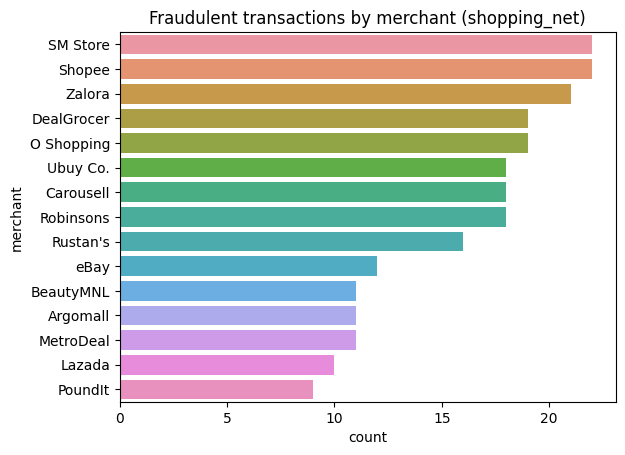

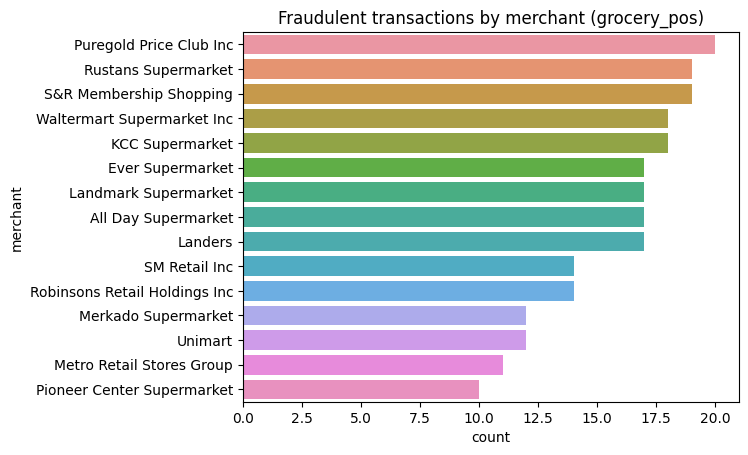

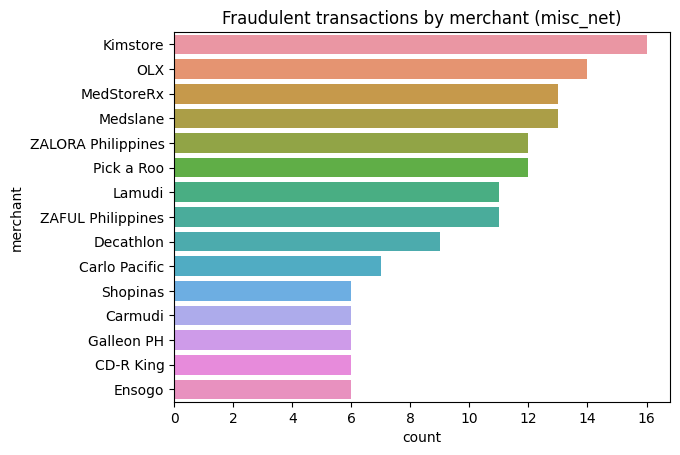

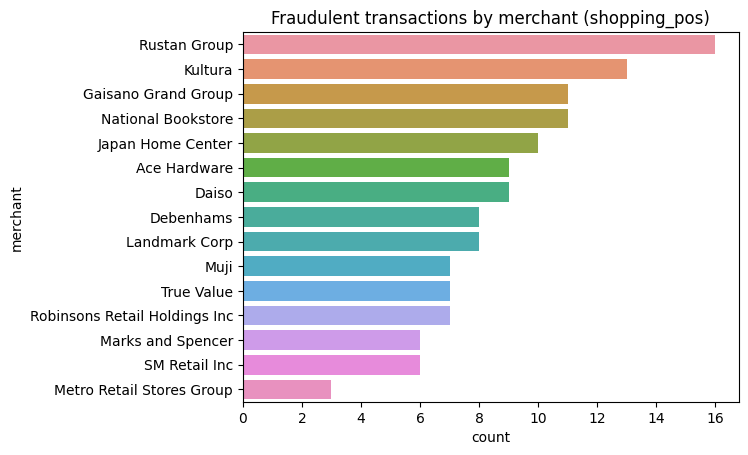

In [50]:
for nm in top_cat:
    temp = cc_clean[(cc_clean['is_fraud'] == 1) & (cc_clean['category'] == nm)]

    sns.countplot(y='merchant',data=temp,
                order = temp['merchant'].value_counts().iloc[:20].index).set(
        title = 'Fraudulent transactions by merchant (' + nm + ')'
    )    

    plt.show()

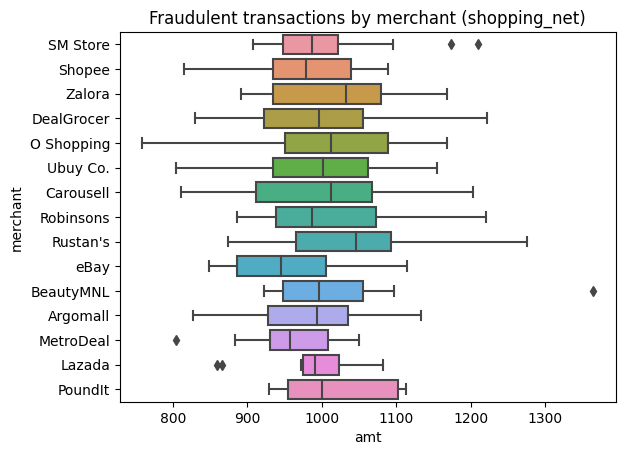

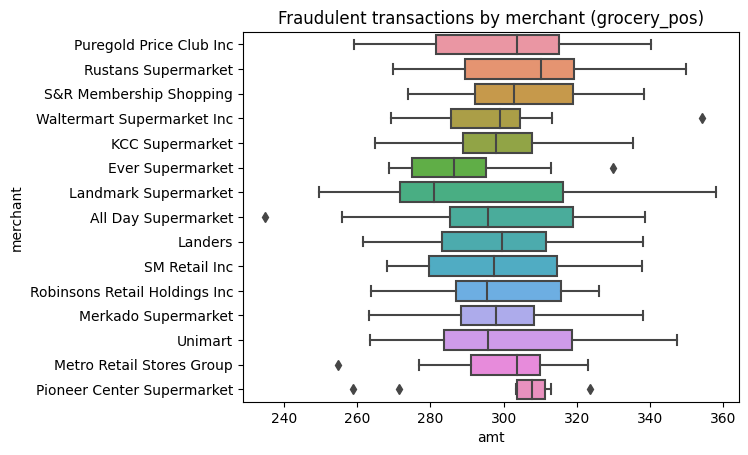

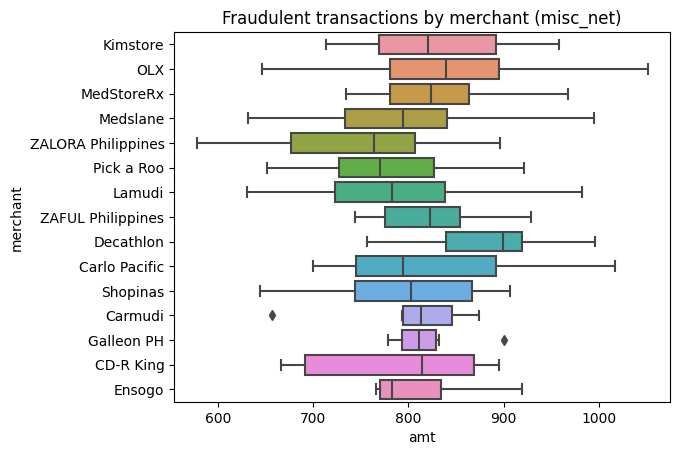

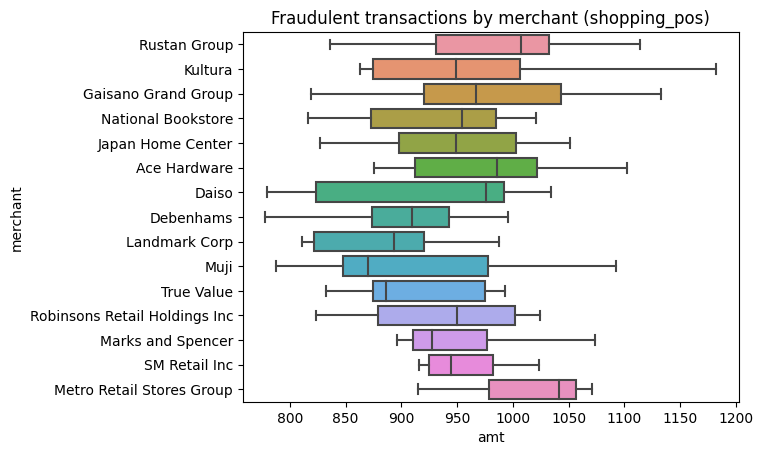

In [56]:
for nm in top_cat:
    temp = cc_clean[(cc_clean['is_fraud'] == 1) & (cc_clean['category'] == nm)]

    sns.boxplot(y='merchant', x= 'amt',data=temp,
                order = temp['merchant'].value_counts().iloc[:20].index).set(
        title = 'Fraudulent transactions by merchant (' + nm + ')'
    )

    plt.show()

[Text(0.5, 1.0, 'Fraudulent transactions by category')]

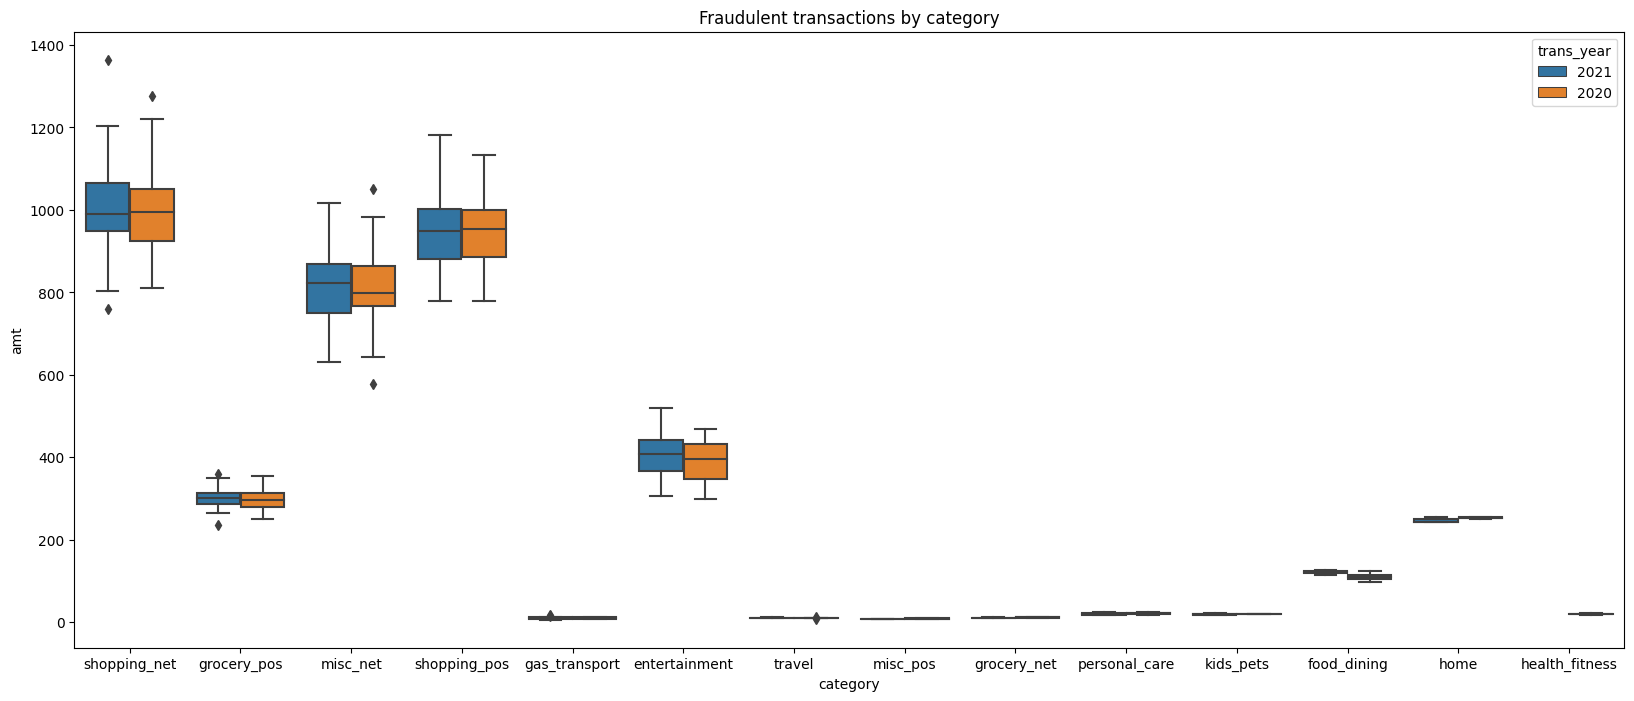

In [39]:
plt.figure(figsize=(20,8))

sns.boxplot(x='category', y= 'amt', hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1],
             order = cc_clean[cc_clean['is_fraud'] == 1]['category'].value_counts().index).set(
    title = 'Fraudulent transactions by category'
)       

[Text(0.5, 1.0, 'Transactions per month')]

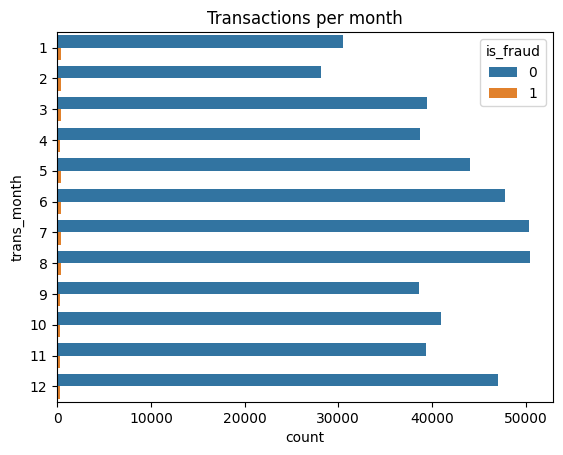

In [11]:
sns.countplot(y='trans_month',hue= 'is_fraud',data=cc_clean).set(title ='Transactions per month')

[Text(0.5, 1.0, 'Number of Fraud Transactions per Month')]

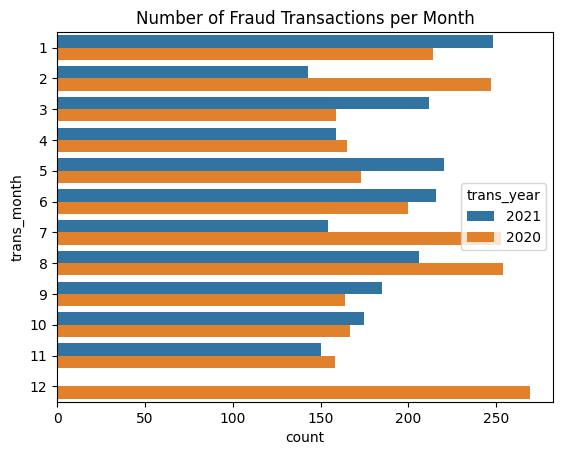

In [12]:
sns.countplot(y='trans_month',hue= 'trans_year',data=cc_clean[cc_clean['is_fraud'] == 1]).set(title = 'Number of Fraud Transactions per Month')

In [13]:
mem_summary = cc_clean[['full_name', 'is_fraud', 'trans_year']]
mem_transactions = pd.DataFrame(mem_summary.groupby(['full_name']).count()['is_fraud']).reset_index()
mem_transactions = mem_transactions.rename(columns={"is_fraud":"trans_count"})

In [14]:
mem_fraud_cnt = pd.DataFrame(mem_summary[mem_summary['is_fraud'] == 1].groupby(['full_name']).count()['is_fraud']).reset_index()
mem_fraud_cnt = mem_fraud_cnt.rename(columns={"is_fraud":"fraud_count"})

In [15]:
mem_trans_cnt = mem_transactions.merge(mem_fraud_cnt, on = 'full_name', how = 'outer')
mem_trans_cnt['perc_fraud'] = 100*(mem_trans_cnt['fraud_count']/mem_trans_cnt['trans_count'])
mem_trans_cnt['w_fraud'] = np.where(mem_trans_cnt['fraud_count']>0, 1, 0)
mem_trans_cnt

,full_name,trans_count,fraud_count,perc_fraud,w_fraud
0,Aaron Chase,2102,9.0,0.428164,1
1,Aaron Heath,711,7.0,0.984529,1
2,Aaron Suarez,1415,10.0,0.706714,1
3,Aaron Walker,10,10.0,100.000000,1
4,Adam Brown,2123,12.0,0.565238,1
...,...,...,...,...,...
465,Willie Davis,1418,10.0,0.705219,1
466,Wyatt Davis,1417,8.0,0.564573,1
467,Zachary Andrews,11,11.0,100.000000,1
468,Zachary Johnson,2113,7.0,0.331283,1


Average number of transactions per person: 1063.83
Minimum number of transactions: 7
Maximum number of transactions: 3532

Number of people with all fraud transactions: 117
Minimum fraud transaction count (all_fraud): 7.0
Maximum fraud transaction count (all_fraud): 12.0


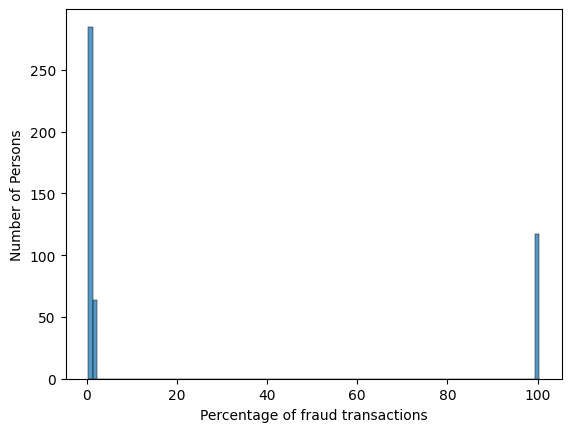

In [26]:
sns.histplot(data = mem_trans_cnt, x = 'perc_fraud', binwidth = 1)
plt.xlabel('Percentage of fraud transactions')
plt.ylabel('Number of Persons')

print ("Average number of transactions per person:", round(np.mean(mem_trans_cnt['trans_count']),2))
print ("Minimum number of transactions:", min(mem_trans_cnt['trans_count']))
print ("Maximum number of transactions:", max(mem_trans_cnt['trans_count']))

all_fraud_mems = mem_trans_cnt[mem_trans_cnt['perc_fraud'] == 100]
print ("\nNumber of people with all fraud transactions:", len(all_fraud_mems))
print ("Minimum fraud transaction count (all_fraud):", min(all_fraud_mems['fraud_count']))
print ("Maximum fraud transaction count (all_fraud):", max(all_fraud_mems['fraud_count']))

Number of people with less than 50% fraud transactions: 349
Max percentage(%) of fraud transactions: 1.68


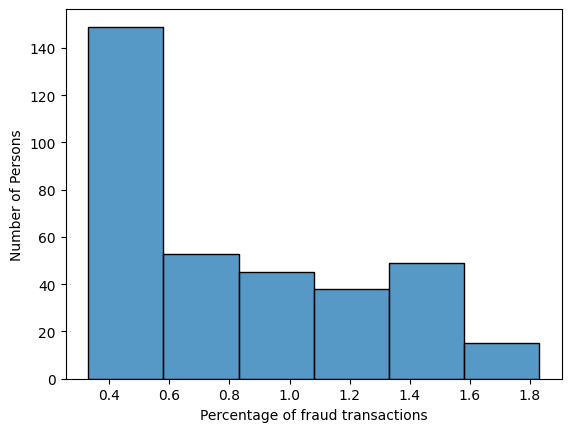

In [17]:
less_50_perc_fraud = mem_trans_cnt[mem_trans_cnt['perc_fraud'] < 50]
sns.histplot(data = less_50_perc_fraud, x = 'perc_fraud', binwidth = 0.25)
plt.xlabel('Percentage of fraud transactions')
plt.ylabel('Number of Persons')

print ("Number of people with less than 50% fraud transactions:", len(less_50_perc_fraud))
print ("Max percentage(%) of fraud transactions:", round(max(less_50_perc_fraud['perc_fraud']), 2))

Text(0.5, 1.0, 'Number of individuals with fraud transactions')

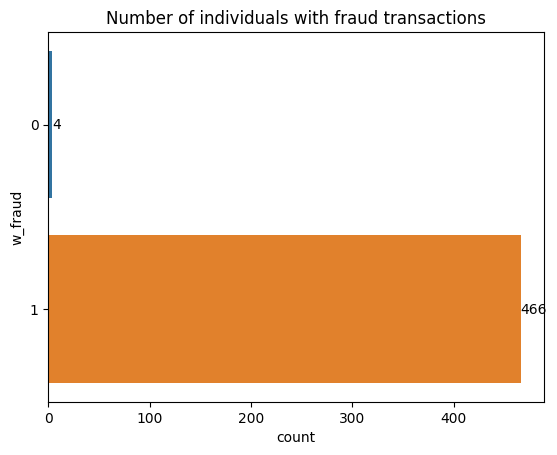

In [18]:
ax =sns.countplot(y='w_fraud',data=mem_trans_cnt)
ax.bar_label(ax.containers[0])
plt.title('Number of individuals with fraud transactions')

## Summary of different models

| Model | Parameters Tuned | Best Model Parameters | Accuracy | Run time |
| --- | --- | --- | --: | --- |
| Logistic Regression | Random_state: [1 to 10] <br>Alpha: [1e-11, 1e-10,1e-9,1e-8, 1e-5, 1e-3, 0.1] | Random_state: 10<br> Alpha: 1e-10 | 99.08 | 3 mins 34 secs |
| KNN Classifier | n_neighbors: [2 to 6] <br> data split: train-test split, 5-fold crossvalidation| n_neighbors (train-test split): 2 <br> n_neighbors (crossvalidation): 6 | 99.31 <br> 90.79 | 5mins 38secs* <br>  51mins 54 secs|
| Random Forest | max_depth = [1 to 10] <br>n_estimators = [1 to 10] <br><br> max_depth = [1 to 10]<br>max_features = [60, 80, 100, 120, 140]| max_depth = 7 <br>n_estimators = 1 <br><br> max_depth = 10 <br>max_features = 120 | 99.08<br><br><br>99.19 | 3mins 28secs<br><br><br>16mins 44secs |
| Gradient Boosting | max_depth = [1 to 10] <br>random_state = [1 to 10] <br><br> n_estimators = [1 to 99] <br> random_state = [1 to 10] | max_depth = 8 <br><br> n_estimators = 8 <br> |  99.51  <br><br><br> 99.56  | 40 mins 6 secs  <br><br><br> 35 mins 36 secs  |
| Ada Boosting | n_estimators = [1 to 10]<br>random_state = [1 to 10]<br>**tried learning rate, interestingly accuracy is terrible (<1%)| n_estimators = 7<br>random_state = 7 | 99.77 | 10 minutes 47 seconds |
| ExtraTreesBoosting | max_depth = [1 to 10] <br> n_estimators = 100 <br> random_state = [1 to 10]| max_depth = --- <br> n_estimators = 100 <br> random_state = --- | 99.05 | 23 minutes 40.3 seconds |
###### * fitted on 10,000 rows only. fitting on 100,000 rows takes more than 2hrs then crashes 


## Interesting insights

**EDA** (based on 500k subset)  
- Less than 1% of all transaction are fraudulent.  
- Majority of the of the fraud transactions are from internet transactions (shopping_net & misc_net) and POS transactions (grocery_pos & shopping_pos)
- There are more fraud transactions in 2021. Interestingly for the month of December all of the fraud transactions were done in 2021 and none in 2020.
- There are individuals where all of their transactions are fraudulent.
- Except for 4 people, every person has at least 1 fraudulent transaction.

**Model Tuning**
- Logistic Regression
  - Found a pattern that accuracy goes constant from alpha: 1e-5  and higher. Tried to go backwards, included smaller numbers and found that the results plateaus  from 1e-13 and lower. Limited the range of alpha from 1e-15 to 0.1 to lessen the runtime. Accuracy is at its best in random_state: 1 and 10.
- Random Forest
  - Training and test accuracies are high on n_estimators 1 to 3 but drops after the 3rd n_estimator and beyond
  - Average training and test accuracy increases from 60 features and reaches maximum accuracy at 120 features.
- Ada Boosting
  - After a set amount of estimators (in this case, 7), accuracy for both test and training plateaus, due to the iterations leading to more accurate estimators that predict examples correctly